In [5]:
import os, h5py, pandas as pd, sys
import numpy as np
srcpath = os.path.join(os.getcwd(), '..')
sys.path.append(srcpath)
import tensorflow as tf
from tensorflow import keras as tfk
from tfomics import tfomics
from tfomics.tfomics import moana, impress
import logomaker
import inspect

from paramiko import SSHClient
from scp import SCPClient

#from pairwise_conv_1d import PairwiseConv1D, PairwiseFromStdConv1D
from ho_conv import HigherOrderConv1D
#from nearest_neighbor_conv_1d import NearestNeighborConv1D, NearestNeighborFromStdConv1D
from ho_regularizer import HigherOrderKernelRegularizer

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
class PairwiseConv1D(HigherOrderConv1D):
    """
    Pairwise convolution on 1D signals. 
    """
    def build(self, input_shape):
        A = input_shape[-1]
        P = self.kernel_size[0]
        C = self.filters
        flat_size = A*P
        if isinstance(self.kernel_regularizer, HigherOrderKernelRegularizer):
            diag_regularizer=self.kernel_regularizer.diag_regularizer
            offdiag_regularizer=self.kernel_regularizer.offdiag_regularizer
        else:
            diag_regularizer=self.kernel_regularizer 
            offdiag_regularizer=self.kernel_regularizer
        
        # set up the diagonal kernel 
        diag_shape = [flat_size, C]
        self.diag_kernel = self.add_weight(
                                    name="diag_kernel",
                                    shape=diag_shape,
                                    regularizer=diag_regularizer,
                                    initializer=self.kernel_initializer, 
                                    constraint=self.kernel_constraint,
                                    trainable=True, 
                                    dtype=self.dtype
                                        )
        
        # set up the offdiagonal kernel 
        num_rows = P - 1 
        block_size = A*A
        num_blocks = int(0.5 * num_rows *(num_rows+1))
        offdiag_shape = [num_blocks*block_size, C]
        self.offdiag_kernel = self.add_weight(
                                        name="offdiag_kernel", 
                                        shape=offdiag_shape,
                                        regularizer=offdiag_regularizer,
                                        initializer=self.kernel_initializer,
                                        constraint=self.kernel_constraint,
                                        trainable=True,
                                        dtype=self.dtype
                                        )
        
        # set up the bias 
        if self.use_bias:
            self.bias = self.add_weight(
                                    name="bias", 
                                    shape=(self.filters,),
                                    initializer=self.bias_initializer, 
                                    constraint=self.bias_constraint, 
                                    regularizer=self.bias_regularizer, 
                                    trainable=True, 
                                    dtype=self.dtype
                                    )
        else:
            self.bias = None
        self.built = True
    
    def _get_diag_kernel(self):
        diag = tf.transpose(self.diag_kernel, [1, 0]) ## (C, P*A)
        diag = tf.linalg.diag(diag) ## (C, P*A, P*A)
        return diag
    
    def _get_offdiag_kernel(self):
        P = self.kernel_size[0]
        flat_size = self.diag_kernel.shape[0] ## P*A
        A = int(flat_size/P)
        offdiag = tf.transpose(self.offdiag_kernel, [1, 0]) ## (C, num_offdiag)
        num_rows = P-1
        block_size = A*A
        C = self.filters 
        
        # get the rows (upto 2nd last row)
        rows = []
        start_idx = 0
        for num_blocks in range(num_rows, 0, -1):
            num_zero_blocks = P - num_blocks
            zeros = tf.zeros((C, A, A*num_zero_blocks), dtype=offdiag.dtype)
            num_elements = num_blocks * block_size
            
            # get the elements of the current row 
            row = offdiag[:, start_idx:start_idx+num_elements] ## (C, num_row_elements)
            row = tf.reshape(row, (C, A, num_blocks*A)) ## (C, A, numblock*A)
            row = tf.concat([zeros, row], 2) ## (C, A, P*A)
            start_idx = start_idx + num_elements
            rows.append(row)
        
        # get the last row 
        rows.append(tf.zeros((C, A, P*A))) ## (C, A, P*A)
        
        rows = tf.concat(rows, axis=1) ## (C, P*A, P*A)
        return rows
    
    @property
    def kernel(self):
        diag = self._get_diag_kernel() ## (C, P*A, P*A)
        offdiag = self._get_offdiag_kernel() ## (C, P*A, P*A)
        kern = diag+offdiag ## (C, P*A, P*A)
        kern = tf.transpose(kern, [1, 2, 0])
        return kern

In [21]:
class NearestNeighborConv1D(HigherOrderConv1D):
    """
    Nearest neighbor convolution on 1D signals. 
    """
    def build(self, input_shape):
        A = input_shape[-1]
        P = self.kernel_size[0]
        C = self.filters
        flat_size = A*P
        if isinstance(self.kernel_regularizer, HigherOrderKernelRegularizer):
            diag_regularizer=self.kernel_regularizer.diag_regularizer
            offdiag_regularizer=self.kernel_regularizer.offdiag_regularizer
        else:
            diag_regularizer=self.kernel_regularizer 
            offdiag_regularizer=self.kernel_regularizer
        
        # set up the diagonal kernel 
        diag_shape = [flat_size, C]
        self.diag_kernel = self.add_weight(
                                    name="diag_kernel",
                                    shape=diag_shape,
                                    regularizer=diag_regularizer,
                                    initializer=self.kernel_initializer, 
                                    constraint=self.kernel_constraint,
                                    trainable=True, 
                                    dtype=self.dtype
                                        )
        
        # set up the offdiagonal kernel 
        block_size = A*A
        num_blocks = P - 1
        offdiag_shape = [num_blocks*block_size, C]
        self.offdiag_kernel = self.add_weight(
                                        name="offdiag_kernel", 
                                        shape=offdiag_shape,
                                        regularizer=offdiag_regularizer,
                                        initializer=self.kernel_initializer,
                                        constraint=self.kernel_constraint,
                                        trainable=True,
                                        dtype=self.dtype
                                        )
        
        # set up the bias 
        if self.use_bias:
            self.bias = self.add_weight(
                                    name="bias", 
                                    shape=(self.filters,),
                                    initializer=self.bias_initializer, 
                                    constraint=self.bias_constraint, 
                                    regularizer=self.bias_regularizer, 
                                    trainable=True, 
                                    dtype=self.dtype
                                    )
        else:
            self.bias = None
        self.built = True
    
    def _get_diag_kernel(self):
        diag = tf.transpose(self.diag_kernel, [1, 0]) ## (C, P*A)
        diag = tf.linalg.diag(diag) ## (C, P*A, P*A)
        return diag
    
    def _get_offdiag_kernel(self):
        P = self.kernel_size[0]
        flat_size = self.diag_kernel.shape[0] ## P*A
        A = int(flat_size/P)
        offdiag = tf.transpose(self.offdiag_kernel, [1, 0]) ## (C, num_offdiag)
        num_rows = P-1
        block_size = A*A
        C = self.filters 
        
        # get the rows (upto 2nd last row)
        rows = []
        start_idx = 0
        for i in range(1, P):
            zeros1 = tf.zeros((C, A, A*i), dtype=offdiag.dtype)
            row = offdiag[:, start_idx:start_idx+block_size] ## (C, A*A)
            row = tf.reshape(row, (C, A, A)) ## (C, A, A)
            zeros2 = tf.zeros((C, A, A*(P-1-i)))
            row = tf.concat([zeros1, row, zeros2], axis=2)
            rows.append(row)
        
        # get the last row 
        rows.append(tf.zeros((C, A, P*A), dtype=offdiag.dtype)) ## (C, A, P*A)
        
        rows = tf.concat(rows, axis=1) ## (C, P*A, P*A)
        return rows
        
    @property
    def kernel(self):
        diag = self._get_diag_kernel() ## (C, P*A, P*A)
        offdiag = self._get_offdiag_kernel() ## (C, P*A, P*A)
        kern = diag+offdiag ## (C, P*A, P*A)
        kern = tf.transpose(kern, [1, 2, 0])
        return kern

In [22]:
class PairwiseFromStdConv1D(PairwiseConv1D):
    def __init__(self, 
                stdconv, 
                offdiag_regularizer=None, 
                offdiag_initializer="zeros", 
                offdiag_constraint=None):
        assert isinstance(stdconv, tfk.layers.Conv1D), 'stdconv has to be an instance keras.layers.Conv1D.'
        argspec = inspect.getfullargspec(stdconv.__init__)
        args = argspec.args[1:]
        super_kwargs = {}
        for arg in args:
            super_kwargs[arg] = eval("stdconv.%s"%arg)
        super().__init__(**super_kwargs)

        # set up the diagonal kernel 
        self.A = stdconv.kernel.shape[1]
        diag_kern = tf.convert_to_tensor(stdconv.kernel.numpy(), dtype=self.dtype)
        diag_kern = tf.reshape(diag_kern, (-1, self.filters))
        self.diag_kernel = tf.Variable(name='diag_kernel',
                                    initial_value=diag_kern,
                                    dtype=self.dtype,
                                    trainable=False,
                                    )

        # set up the bias 
        if self.use_bias:
            self.bias = tf.Variable(initial_value=stdconv.bias, dtype=self.dtype, trainable=False, name='bias')
        else:
            self.bias = None
        
        # add the remaining initializer args 
        self.offdiag_regularizer=offdiag_regularizer
        self.offdiag_initializer=offdiag_initializer 
        self.offdiag_constraint=offdiag_constraint

    def build(self, input_shape):
        A = input_shape[-1]
        assert A == self.A, 'Invalid shape.'
        P = self.kernel_size[0]
        flat_size = A*P
        C = self.filters 

        # set up the offdiagonal kernel 
        num_rows = P - 1 
        block_size = A*A
        num_blocks = int(0.5 * num_rows *(num_rows+1))
        offdiag_shape = [num_blocks*block_size, C]
        self.offdiag_kernel = self.add_weight(
                                        name="offdiag_kernel", 
                                        shape=offdiag_shape,
                                        regularizer=self.offdiag_regularizer,
                                        initializer=self.offdiag_initializer,
                                        constraint=self.offdiag_constraint,
                                        trainable=True,
                                        dtype=self.dtype
                                        )
        self.built = True

In [34]:
class NearestNeighborFromStdConv1D(NearestNeighborConv1D):
    def __init__(self, 
                stdconv, 
                offdiag_regularizer=None, 
                offdiag_initializer="zeros", 
                offdiag_constraint=None):
        assert isinstance(stdconv, tfk.layers.Conv1D), 'stdconv has to be an instance keras.layers.Conv1D.'
        argspec = inspect.getfullargspec(stdconv.__init__)
        args = argspec.args[1:]
        super_kwargs = {}
        for arg in args:
            super_kwargs[arg] = eval("stdconv.%s"%arg)
        super().__init__(**super_kwargs)

        # set up the diagonal kernel 
        self.A = stdconv.kernel.shape[1]
        diag_kern = tf.convert_to_tensor(stdconv.kernel.numpy(), dtype=self.dtype)
        diag_kern = tf.reshape(diag_kern, (-1, self.filters))
        self.diag_kernel = tf.Variable(name='diag_kernel',
                                    initial_value=diag_kern,
                                    dtype=self.dtype,
                                    trainable=False,
                                    )

        # set up the bias 
        if self.use_bias:
            self.bias = tf.Variable(initial_value=stdconv.bias, dtype=self.dtype, trainable=False, name='bias')
        else:
            self.bias = None
        
        # add the remaining initializer args 
        self.offdiag_regularizer=offdiag_regularizer
        self.offdiag_initializer=offdiag_initializer 
        self.offdiag_constraint=offdiag_constraint

    def build(self, input_shape):
        A = input_shape[-1]
        assert A == self.A, 'Invalid shape.'
        P = self.kernel_size[0]
        flat_size = A*P
        C = self.filters 

        # set up the offdiagonal kernel 
        block_size = A*A
        num_blocks = P-1
        offdiag_shape = [num_blocks*block_size, C]
        self.offdiag_kernel = self.add_weight(
                                        name="offdiag_kernel", 
                                        shape=offdiag_shape,
                                        regularizer=self.offdiag_regularizer,
                                        initializer=self.offdiag_initializer,
                                        constraint=self.offdiag_constraint,
                                        trainable=True,
                                        dtype=self.dtype
                                        )
        self.built = True

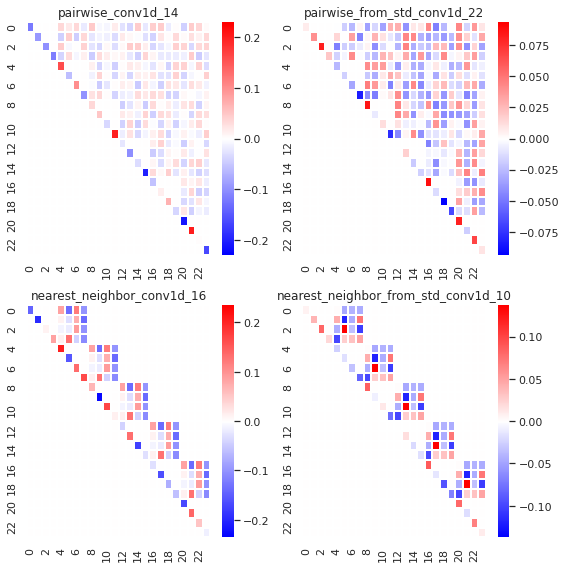

In [44]:
diag_regularizer = tfk.regularizers.l2(1e-6)
offdiag_regularizer = tfk.regularizers.l1_l2(l1=1e-3, l2=1e-3)
kernel_regularizer = HigherOrderKernelRegularizer(diag_regularizer=diag_regularizer,
                                                 offdiag_regularizer=offdiag_regularizer)
conv_kwargs = {'filters':32, 'kernel_size':19, 
               'padding':'same'}
stdconv = tfk.layers.Conv1D(kernel_regularizer=diag_regularizer, **conv_kwargs)

x = tf.random.normal((2, 50, 4))
y = stdconv(x)
#print(x.shape, y.shape, stdconv.kernel.shape)

pconv1 = PairwiseConv1D(kernel_regularizer=kernel_regularizer, **conv_kwargs)
pconv2 = PairwiseFromStdConv1D(stdconv=stdconv, offdiag_initializer=tfk.initializers.he_uniform,
                               offdiag_regularizer=offdiag_regularizer)
nnconv1 = NearestNeighborConv1D(kernel_regularizer=kernel_regularizer, **conv_kwargs)
nnconv2 = NearestNeighborFromStdConv1D(stdconv=stdconv, offdiag_initializer=tfk.initializers.he_uniform,
                               offdiag_regularizer=offdiag_regularizer)

layers = [pconv1, pconv2, nnconv1, nnconv2]

fig, ax = plt.subplots(2, 2, figsize=(8,8))
for i, layer in enumerate(layers):
    layer.build((50,4))
    K = tf.transpose(layer.kernel, (2, 0, 1)).numpy()
    VAL = np.maximum(np.abs(K[0].max()), np.abs(K[0].min()))
    k = K[0]
    sns.heatmap(k[:24, :24], vmax=VAL, vmin=-VAL, cmap='bwr', linewidths=1, ax=ax[i//2, i%2])
    ax[i//2, i%2].set_title(layer.name)
fig.tight_layout()

In [41]:
print(pconv1.offdiag_kernel.shape, pconv2.offdiag_kernel.shape)

(2736, 32) (2736, 32)


<AxesSubplot:>

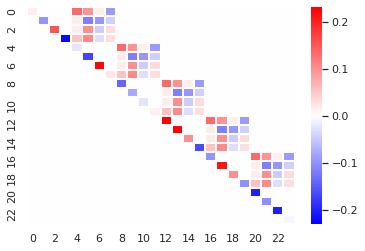

In [29]:
K = tf.transpose(conv.kernel, (2, 0, 1)).numpy()
VAL = np.maximum(np.abs(K[0].max()), np.abs(K[0].min()))
k = K[0]
sns.heatmap(k[:24, :24], vmax=VAL, vmin=-VAL, cmap='bwr', linewidths=1)

In [19]:
diag_regularizer = tfk.regularizers.l2(1e-6)
offdiag_regularizer = tfk.regularizers.l1_l2(l1=1e-3, l2=1e-3)
kernel_regularizer = HigherOrderKernelRegularizer(diag_regularizer=diag_regularizer,
                                                 offdiag_regularizer=offdiag_regularizer)
conv_kwargs = {'filters':32, 'kernel_size':19, 
               'padding':'same'}
stdconv = tfk.layers.Conv1D(kernel_regularizer=diag_regularizer, **conv_kwargs)
#conv = PairwiseConv1D(**conv_kwargs)
x = tf.random.normal((2, 50, 4))
y = stdconv(x)
print(x.shape, y.shape, stdconv.kernel.shape)

conv = PairwiseFromStdConv1D(stdconv)
y = conv(x)
print(x.shape, y.shape, conv.kernel.shape)

conv = PairwiseConv1D(**conv_kwargs)
y = conv(x)
print(x.shape, y.shape, conv.kernel.shape)

for v in conv.trainable_variables:
    print(v.name, v.shape)

(2, 50, 4) (2, 50, 32) (19, 4, 32)
(2, 50, 4) (2, 50, 32) (76, 76, 32)
(2, 50, 4) (2, 50, 32) (76, 76, 32)
pairwise_conv1d_2/diag_kernel:0 (76, 32)
pairwise_conv1d_2/offdiag_kernel:0 (2736, 32)
pairwise_conv1d_2/bias:0 (32,)


In [ ]:
class Neares(HigherOrderConv1D):
    """
    Pairwise convolution on 1D signals. 
    """
    def build(self, input_shape):
        A = input_shape[-1]
        P = self.kernel_size[0]
        C = self.filters
        flat_size = A*P
        if isinstance(self.kernel_regularizer, HigherOrderKernelRegularizer):
            diag_regularizer=self.kernel_regularizer.diag_regularizer
            offdiag_regularizer=self.kernel_regularizer.offdiag_regularizer
        else:
            diag_regularizer=self.kernel_regularizer 
            offdiag_regularizer=self.kernel_regularizer

In [ ]:
K = tf.transpose(conv.kernel, (2, 0, 1)).numpy()
VAL = np.maximum(np.abs(K[0].max()), np.abs(K[0].min()))
k = K[0]
sns.heatmap(k[:12, :12], vmax=VAL, vmin=-VAL, cmap='bwr', linewidths=1)

In [ ]:
print()

In [ ]:
x1 = tf.random.normal((1, 2))
x2 = tf.random.normal((1, 5))
print(x1)
print(x2)
print(tf.concat([x1, x2], 1))

In [ ]:
for i in range(5,0,-1):
    print(i)

In [ ]:
diag_regularizer = tfk.regularizers.l2(1e-6)
offdiag_regularizer = tfk.regularizers.l1_l2(l1=1e-3, l2=1e-3)
kernel_regularizer = HigherOrderKernelRegularizer(diag_regularizer=diag_regularizer,
                                                 offdiag_regularizer=offdiag_regularizer)
conv_kwargs = {'filters':32, 'kernel_size':19, 
               'padding':'same', 'kernel_regularizer':kernel_regularizer}
conv = PairwiseConv1D(**conv_kwargs)
x = tf.random.normal((2, 50, 4))
y = conv(x)
print(x.shape, y.shape)

In [ ]:
for v in (conv.trainable_variables):
    print(v.name, v.shape)

In [ ]:
# # set up ssh and scp connection 
# username, hostname = os.getenv('BAMDEV1').split("@")
# ssh = SSHClient()
# ssh.load_system_host_keys()
# ssh.connect(hostname=hostname, username=username)
# remotehome = ssh.exec_command("echo $HOME")[1].readlines()[0].strip()
# scp = SCPClient(ssh.get_transport())
# REMOTEDATADIR = os.path.join(remotehome, "projects/higher_order_convolutions", 'data', 'deepbind_encode_chipseq')

In [ ]:
# download data for a particular tfid
tfid = "POLR2A_K562_Pol2_HudsonAlpha"
print("Downloading data ...")
if not os.path.exists("data.h5"):
    scp.get(remote_path=os.path.join(REMOTEDATADIR, tfid, 'data.h5'))
print("Loading data ...")
data = h5py.File('data.h5', 'r')
x_train = data['X_train'][:]
y_train = data['Y_train'][:]
x_test = data['X_test'][:]
y_test = data['Y_test'][:]
if y_train.ndim == 1:
    y_train = y_train[:, None]
if y_test.ndim == 1:
    y_test = y_test[:, None]
data.close()
!rm data.h5

### `CNN-25` model definition

In [ ]:
conv_type_dict = {'standard':tfk.layers.Conv1D, 'pairwise':PairwiseConv1D, 'nearest_neighbor':NearestNeighborConv1D}

def cnn25_model(input_shape, first_conv_layer):
    """
    Set up the first convolutional layer outside this function. 
    """
    x = tfk.layers.Input(shape=input_shape, name='input')
    
    # 1st conv layer
    assert isinstance(first_conv_layer, tfk.layers.Conv1D)
    y = first_conv_layer(x)
    y = tfk.layers.BatchNormalization()(y)
    y = tfk.layers.Activation('relu')(y)
    y = tfk.layers.MaxPool1D(pool_size=25)(y)
    y = tfk.layers.Dropout(0.2)(y)
    
    # remaining layers 
    y = tfk.layers.Conv1D(filters=128, kernel_size=7, padding='same', kernel_regularizer=tfk.regularizers.l2(1e-6))(y)
    y = tfk.layers.BatchNormalization()(y)
    y = tfk.layers.Activation('relu')(y)
    y = tfk.layers.MaxPool1D(pool_size=2)(y) 
    y = tfk.layers.Dropout(0.2)(y)
    
    y = tfk.layers.Flatten()(y)
    y = tfk.layers.Dense(512, kernel_regularizer=tfk.regularizers.l2(1e-6))(y)      
    y = tfk.layers.BatchNormalization()(y)
    y = tfk.layers.Activation('relu')(y)
    y = tfk.layers.Dropout(0.5)(y)
    
    y = tfk.layers.Dense(1, name='logits')(y) ## logits
    y = tfk.layers.Activation('sigmoid', name='output')(y) ## final output 
    
    model = tfk.Model(inputs=x, outputs=y, name='cnn-25')
    
    return model

### `CNN-25` with standard 1st layer convolution

#### Train the standard and pairwise conv models 

In [ ]:
# set up the model 
input_shape = x_train.shape[1:]
diag_regularizer = tfk.regularizers.l2(1e-6)
conv_kwargs = {'filters':32, 'kernel_size':19, 
               'padding':'same', 'kernel_regularizer':diag_regularizer}
first_conv_layer = tfk.layers.Conv1D(**conv_kwargs)
stdmodel = cnn25_model(input_shape=input_shape, first_conv_layer=first_conv_layer)

# compile the conv model 
lossfn = tfk.losses.binary_crossentropy
optimizer = tfk.optimizers.Adam(learning_rate=1e-3)
aupr = tfk.metrics.AUC(curve='PR', name='AUPR')
auroc = tfk.metrics.AUC(curve='ROC', name='AUROC')
acc = tfk.metrics.BinaryAccuracy(name='ACC')
metrics = [acc, auroc, aupr]
compile_options = {'loss':lossfn, 'optimizer':optimizer, 'metrics':metrics}
stdmodel.compile(**compile_options)

# setup callback 
es = tfk.callbacks.EarlyStopping(monitor='val_AUROC', patience=10, verbose=1, mode='max')
reduce_lr = tfk.callbacks.ReduceLROnPlateau(monitor='val_AUROC', factor=0.1,
                                                 patience=10, min_lr=1e-7,mode='max',verbose=0)
callbacks = [es, reduce_lr]
    
# fit model 
print("Fit model with standard convolution 1st layer...")
batch_size = 128
epochs = 40
stdhist=stdmodel.fit(x_train, y_train, 
                     validation_split=0.2, batch_size=batch_size, epochs=epochs, callbacks=callbacks)

In [ ]:
# fit transferred model 
print("Fit model with transferred pairwise convolution 1st layer...")
stdconv = stdmodel.layers[1]
offdiag_regularizer = tfk.regularizers.l1(10.)
pconv = PairwiseFromStdConv1D(stdconv=stdconv, offdiag_regularizer=offdiag_regularizer)
pmodel = cnn25_model(first_conv_layer=pconv, input_shape=input_shape)
compile_options['optimizer'] = tfk.optimizers.Adam(learning_rate=1e-2)
pmodel.compile(**compile_options)
phist = pmodel.fit(x_train, y_train, 
                   validation_split=0.2, batch_size=batch_size, epochs=epochs, callbacks=callbacks)

In [ ]:
# fit pairwise model without tranferring std conv kernel  
offdiag_regularizer = tfk.regularizers.l1(10.)
kernel_regularizer = HigherOrderKernelRegularizer(diag_regularizer=diag_regularizer, 
                                                  offdiag_regularizer=offdiag_regularizer)
conv_kwargs['kernel_regularizer'] = kernel_regularizer
first_conv_layer = PairwiseConv1D(**conv_kwargs)
pmodel2 = cnn25_model(first_conv_layer=first_conv_layer, input_shape=input_shape)
compile_options['optimizer'] = tfk.optimizers.Adam(learning_rate=1e-2)
pmodel2.compile(**compile_options)
phist = pmodel2.fit(x_train, y_train, 
                   validation_split=0.2, batch_size=batch_size, epochs=epochs, callbacks=callbacks)

#### Check training curves; visualize distribution of weights 

In [ ]:
x = np.arange(len(stdhist.history['loss']))
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
for i, name in enumerate(pmodel.metrics_names):
    r, c = int(i/2), int(i%2)
    x = np.arange(len(stdhist.history['loss']))
    ax[r, c].plot(x, stdhist.history['val_%s'%name], label='standard')
    x = np.arange(len(phist.history['loss']))
    ax[r, c].plot(x, phist.history['val_%s'%name], label='pairwise')
    ax[r, c].legend(loc='best', fontsize=15)
    ax[r, c].set_title(name.title())
fig.tight_layout()

In [ ]:
plt.figure(figsize=(12, 5))
h1=plt.hist(pmodel.layers[1].diag_kernel.numpy().flatten(), linewidth=0., bins=50, label='diagonal', density=True)
h2=plt.hist(pmodel.layers[1].offdiag_kernel.numpy().flatten(), linewidth=0., bins=50, label='off diagonal', density=True);
plt.legend(loc='best', fontsize=15)
plt.ylim([0, h2[0].max()]);

#### Compute test metrics 

In [ ]:
y_pred = stdmodel.predict(x_test, verbose=0)
test_metrics = {}
for metric in stdmodel.metrics[1:]:
    test_metrics[metric.name] = [metric(y_test, y_pred).numpy()]
std_df = pd.DataFrame(data=test_metrics, index=['Value'])

In [ ]:
y_pred = pmodel.predict(x_test, verbose=0)
test_metrics = {}
for metric in pmodel.metrics[1:]:
    test_metrics[metric.name] = [metric(y_test, y_pred).numpy()]
p_df = pd.DataFrame(data=test_metrics, index=['Value'])

In [ ]:
y_pred = pmodel2.predict(x_test, verbose=0)
test_metrics = {}
for metric in pmodel2.metrics[1:]:
    test_metrics[metric.name] = [metric(y_test, y_pred).numpy()]
p2_df = pd.DataFrame(data=test_metrics, index=['Value'])

In [ ]:
std_df

In [ ]:
p_df

In [ ]:
p2_df

#### Visualize the filters 

In [ ]:
# filter visualization 
fig = plt.figure(figsize=(20,12))
filters = moana.filter_activations(x_test, pmodel2, layer=3, window=20, threshold=0.5)
impress.plot_filters(filters, fig, num_cols=4, alphabet='ACGT');

In [ ]:
# filter visualization 
fig = plt.figure(figsize=(20,12))
filters = moana.filter_activations(x_test, stdmodel, layer=3, window=20, threshold=0.5)
impress.plot_filters(filters, fig, num_cols=4, alphabet='ACGT');

In [ ]:
# filter visualization 
fig = plt.figure(figsize=(20,12))
filters = moana.filter_activations(x_test, pmodel, layer=3, window=20, threshold=0.5)
impress.plot_filters(filters, fig, num_cols=4, alphabet='ACGT');

### `CNN-25` with pairwise convolution as the 1st layer 

In [ ]:
# set up the first layer conv layer and the full model 
stdconv = stdmodel.layers[1]
offdiag_regularizer = tfk.regularizers.l1(1e-2)
first_conv_layer = PairwiseFromStdConv1D(stdconv=stdconv, offdiag_regularizer=offdiag_regularizer)
pmodel = cnn25_model(input_shape=input_shape, first_conv_layer=first_conv_layer)

# compile the conv model 
lossfn = tfk.losses.binary_crossentropy
optimizer = tfk.optimizers.Adam(learning_rate=1e-3)
aupr = tfk.metrics.AUC(curve='PR', name='AUPR')
auroc = tfk.metrics.AUC(curve='ROC', name='AUROC')
acc = tfk.metrics.BinaryAccuracy(name='ACC')
metrics = [acc, auroc, aupr]
compile_options = {'loss':lossfn, 'optimizer':optimizer, 'metrics':metrics}
pmodel.compile(**compile_options)

# setup callback 
es = tfk.callbacks.EarlyStopping(monitor='val_AUROC', patience=10, verbose=1, mode='max')
reduce_lr = tfk.callbacks.ReduceLROnPlateau(monitor='val_AUROC', factor=0.1,
                                                 patience=10, min_lr=1e-7,mode='max',verbose=0)
callbacks = [es, reduce_lr]
    
# fit model 
pmodel.fit(x_train, y_train, validation_split=0.2, batch_size=128, epochs=30, callbacks=callbacks)

In [ ]:
y_pred = pmodel.predict(x_test, verbose=0)
test_metrics = {}
for metric in stdmodel.metrics[1:]:
    test_metrics[metric.name] = [metric(y_test, y_pred).numpy()]
pd.DataFrame(data=test_metrics, index=['Value'])

In [ ]:
# filter visualization 
fig = plt.figure(figsize=(20,12))
filters = moana.filter_activations(x_test, pmodel, layer=3, window=20, threshold=0.5)
impress.plot_filters(filters, fig, num_cols=4, alphabet='ACGT');

In [ ]:
from tfomics import explain, evaluate

In [ ]:
std_explainer = explain.Explainer(stdmodel, class_index=0)
p_explainer = explain.Explainer(pmodel, class_index=0)

std_saliency = std_explainer.saliency_maps(x_test[:500])
p_saliency = p_explainer.saliency_maps(x_test[:500])

std_smoothgrad = std_explainer.smoothgrad(x_test[:500])
p_smoothgrad = p_explainer.smoothgrad(x_test[:500])

In [ ]:
p2_explainer = explain.Explainer(pmodel2, class_index=0)
p2_saliency = p2_explainer.saliency_maps(x_test[:500])
p2_smoothgrad = p2_explainer.smoothgrad(x_test[:500])
alphabet = 'ACGT'
fig = plt.figure(figsize=(20, 4))

ax = fig.add_subplot(211)
df = pd.DataFrame(data=p2_saliency[0], columns=list(alphabet))
logo = logomaker.Logo(df=df, ax=ax)
ax.set_ylabel("Pairwise")
ax.set_title("Saliency map")

ax = fig.add_subplot(212)
df = pd.DataFrame(data=p2_smoothgrad[0], columns=list(alphabet))
logo = logomaker.Logo(df=df, ax=ax)
ax.set_ylabel("Pairwise")
ax.set_title("Smoothgrad")

In [ ]:
alphabet = 'ACGT'

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(411)
df = pd.DataFrame(data=std_saliency[0], columns=list(alphabet))
logo = logomaker.Logo(df=df, ax=ax)
ax.set_ylabel("Standard")
ax.set_title("Saliency map")

ax = fig.add_subplot(412)
df = pd.DataFrame(data=p_saliency[0], columns=list(alphabet))
logo = logomaker.Logo(df=df, ax=ax)
ax.set_ylabel("Pairwise")
ax.set_title("Saliency map")

ax = fig.add_subplot(413)
df = pd.DataFrame(data=std_smoothgrad[0], columns=list(alphabet))
logo = logomaker.Logo(df=df, ax=ax)
ax.set_ylabel("Standard")
ax.set_title("Smoothgrad")

ax = fig.add_subplot(414)
df = pd.DataFrame(data=p_smoothgrad[0], columns=list(alphabet))
logo = logomaker.Logo(df=df, ax=ax)
ax.set_ylabel("pairwise")
ax.set_title("Smoothgrad")

In [ ]:
def analyze(model, num_analyze=200):
    N, L, A = x_train.shape

    # get positive label sequences and sequence model
    pos_index = np.where(y_test[:,0] == 1)[0]   
    X = x_test[pos_index[:num_analyze]] ## examples of the positive class 
    X_model = model_test[pos_index[:num_analyze]]

    # instantiate explainer class
    explainer = explain.Explainer(model, class_index=0)

    # calculate attribution maps
    mutagenesis_scores = explainer.mutagenesis(X, class_index=None)
    saliency_scores = explainer.saliency_maps(X)
    smoothgrad_scores = explainer.smoothgrad(X, num_samples=50, mean=0.0, stddev=0.1)
    intgrad_scores = explainer.integrated_grad(X, baseline_type='zeros')
    expintgrad_scores = explainer.expected_integrated_grad(X, num_baseline=50, baseline_type='random')


    scores_dict = {
    "mutagenesis_scores":mutagenesis_scores,
    "saliency_scores":saliency_scores,
    "smoothgrad_scores":smoothgrad_scores,
    "intgrad_scores":intgrad_scores,
    "expintgrad_scores":expintgrad_scores
    }
    return scores_dict, X, X_model

def reduce(scores_dict, X):
    # reduce attribution maps to 1D scores
    mut_scores = explain.l2_norm(scores_dict["mutagenesis_scores"])
    sal_scores = explain.grad_times_input(X, scores_dict["saliency_scores"])
    sg_scores = explain.grad_times_input(X, scores_dict["smoothgrad_scores"])
    int_scores = explain.grad_times_input(X, scores_dict["intgrad_scores"])
    expint_scores = explain.grad_times_input(X, scores_dict["expintgrad_scores"])
    scores1d_dict = {
                "mut_scores":mut_scores,
                "sal_scores":sal_scores,
                "sg_scores":sg_scores,
                "int_scores":int_scores,
                "expint_scores":expint_scores
                }
    return scores1d_dict, X

def compare_scores(scores1d_dict, X_model):
    # compare distribution of attribution scores at positions with and without motifs
    threshold = 0.1
    mutagenesis_roc, mutagenesis_pr = evaluate.interpretability_performance(scores1d_dict["mut_scores"], X_model, threshold)
    saliency_roc, saliency_pr = evaluate.interpretability_performance(scores1d_dict["sal_scores"], X_model, threshold)
    smoothgrad_roc, smoothgrad_pr = evaluate.interpretability_performance(scores1d_dict["sg_scores"], X_model, threshold)
    intgrad_roc, intgrad_pr = evaluate.interpretability_performance(scores1d_dict["int_scores"], X_model, threshold)
    expintgrad_roc, expintgrad_pr = evaluate.interpretability_performance(scores1d_dict["expint_scores"], X_model, threshold)

    distr_dict = {
            "mutagenesis_roc":mutagenesis_roc,
            "mutagenesis_pr":mutagenesis_pr,
            "saliency_roc":saliency_roc,
            "saliency_pr":saliency_pr,
            "smoothgrad_roc":smoothgrad_roc,
            "smoothgrad_pr":smoothgrad_pr,
            "intgrad_roc":intgrad_roc,
            "intgrad_pr":intgrad_pr,
            "expintgrad_roc":expintgrad_roc,
            "expintgrad_pr":expintgrad_pr,
            }
    return distr_dict, X_model

def print_statistics(distr_dict):
    print("%s: %.3f+/-%.3f"%('mutagenesis', np.mean(distr_dict["mutagenesis_roc"]), np.std(distr_dict["mutagenesis_roc"])))
    print("%s: %.3f+/-%.3f"%('saliency', np.mean(distr_dict["saliency_roc"]), np.std(distr_dict["saliency_roc"])))
    print("%s: %.3f+/-%.3f"%('smoothgrad', np.mean(distr_dict["smoothgrad_roc"]), np.std(distr_dict["smoothgrad_roc"])))
    print("%s: %.3f+/-%.3f"%('intgrad', np.mean(distr_dict["intgrad_roc"]), np.std(distr_dict["intgrad_roc"])))
    print("%s: %.3f+/-%.3f"%('expintgrad', np.mean(distr_dict["expintgrad_roc"]), np.std(distr_dict["expintgrad_roc"])))

    print("%s: %.3f+/-%.3f"%('mutagenesis', np.mean(distr_dict["mutagenesis_pr"]), np.std(distr_dict["mutagenesis_pr"])))
    print("%s: %.3f+/-%.3f"%('saliency', np.mean(distr_dict["saliency_pr"]), np.std(distr_dict["saliency_pr"])))
    print("%s: %.3f+/-%.3f"%('smoothgrad', np.mean(distr_dict["smoothgrad_pr"]), np.std(distr_dict["smoothgrad_pr"])))
    print("%s: %.3f+/-%.3f"%('intgrad', np.mean(distr_dict["intgrad_pr"]), np.std(distr_dict["intgrad_pr"])))
    print("%s: %.3f+/-%.3f"%('expintgrad', np.mean(distr_dict["expintgrad_pr"]), np.std(distr_dict["expintgrad_pr"])))

def dataframe_plot(distr_dict,trial):
    df_names = ['mutagenesis_roc','saliency_roc','smoothgrad_roc','intgrad_roc','expintgrad_roc','mutagenesis_pr','saliency_pr','smoothgrad_pr','intgrad_pr','expintgrad_pr']
    df_values = [np.mean(distr_dict["mutagenesis_roc"]),np.mean(distr_dict["saliency_roc"]),np.mean(distr_dict["smoothgrad_roc"]),np.mean(distr_dict["intgrad_roc"]),np.mean(distr_dict["expintgrad_roc"]),np.mean(distr_dict["mutagenesis_pr"]),np.mean(distr_dict["saliency_pr"]),np.mean(distr_dict["smoothgrad_pr"]),np.mean(distr_dict["intgrad_pr"]),np.mean(distr_dict["expintgrad_pr"])]
    df_std = [np.std(distr_dict["mutagenesis_roc"]),np.std(distr_dict["saliency_roc"]),np.std(distr_dict["smoothgrad_roc"]),np.std(distr_dict["intgrad_roc"]),np.std(distr_dict["expintgrad_roc"]),np.std(distr_dict["mutagenesis_pr"]),np.std(distr_dict["saliency_pr"]),np.std(distr_dict["smoothgrad_pr"]),np.std(distr_dict["intgrad_pr"]),np.std(distr_dict["expintgrad_pr"])]
    df = pd.DataFrame(data={'Name':df_names, 'Values':df_values, 'Standard Deviation':df_std})
    name = trial + '_df'
    df.to_csv(name)
    return df

In [ ]:
tf.abs()

In [ ]:
s

In [ ]:
v @ tf.linalg.diag(e)
#v @ tf.linalg.diag(e) @ tf.transpose(v)

In [ ]:
_W